# Amplitude embedding (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Amplitude embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 4 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = 1 #np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 9.8836870e+00+9.8274246e+01j -1.2720844e-02-1.0360047e-03j
   5.8719193e+01+9.4338196e+01j  4.7947965e-03-8.7603899e-03j]
 [ 9.0997993e+01+9.3576973e+01j  6.6963597e-03-1.1349413e-02j
   4.3299160e+01+2.0914080e+01j  8.0112442e-03+9.4212368e-03j]
 [ 7.4310204e+01+5.6562476e+00j -9.7531043e-03+8.3268592e-03j
   9.9344269e+01+3.5033169e+01j -1.6888814e-02-1.9452954e-02j]
 [-1.9796293e-02+1.1535350e-02j -5.1946472e-03+4.1051656e-03j
   1.5406038e-03+3.0659835e-03j  9.5791481e-03+1.2713528e-04j]]


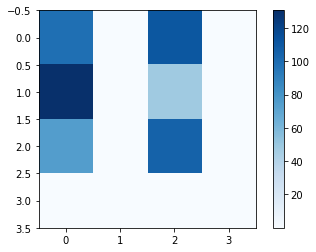

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 376.52078 +347.78888j   -26.173363 +47.25696j   376.55173 +347.82614j
   -26.210785 +47.20402j ]
 [   9.437414 +17.598623j   48.81947  -14.357799j    9.412303 +17.61661j
    48.886497 -14.456599j]
 [ 107.9248  +118.77298j  -121.494774 -98.11794j   108.03211 +118.81943j
  -121.599365 -98.10652j ]
 [-219.50317 +286.2501j    -96.46246  +81.03304j  -219.55292 +286.22678j
   -96.449265 +81.03324j ]]


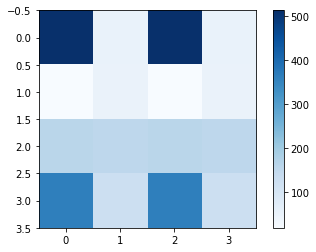

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [6]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 4.695864e-13
Imaginaries MSE: 1.5674729e-12


## 3) Data encoding: amplitude embedding (non-conventional domain)

[[ 376.52078 +347.78888j   -26.173363 +47.25696j   376.5517  +347.82614j
   -26.210785 +47.20402j ]
 [   9.437414 +17.598623j   48.81947  -14.357799j    9.412303 +17.61661j
    48.886497 -14.456599j]
 [ 107.9248  +118.77298j  -121.49477  -98.11794j   108.03211 +118.81943j
  -121.599365 -98.10652j ]
 [-219.50317 +286.2501j    -96.46246  +81.03304j  -219.5529  +286.22678j
   -96.449265 +81.03324j ]]


C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\roman\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcpara

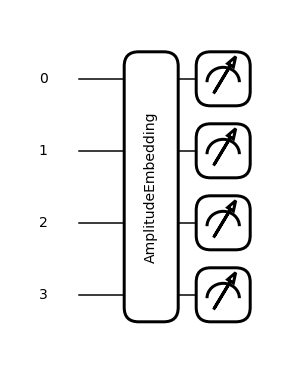

In [7]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

#normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(int(math.log2(n))) # set the number of qubits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=True) 
    return qml.state() #qml.expval(qml.PauliZ(wires=wires))

readout = amp_encoding(normalized_data).astype('complex64')
qml.draw_mpl(amp_encoding)(data)
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

## 4) Applying 2D IFT (fidelity test)

In [8]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 3.7080655e-12
Imaginaries MSE: 2.153093e-12


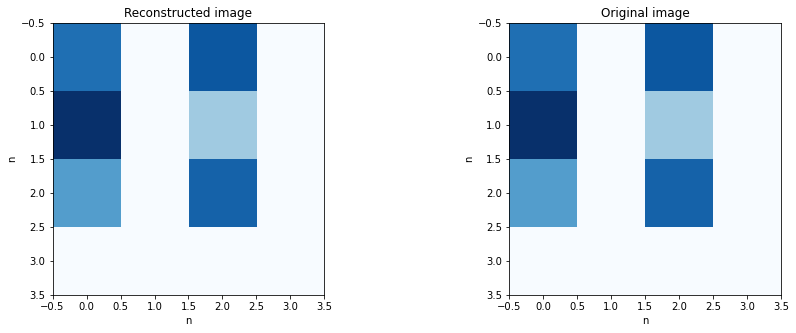

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')